# Manipulate data
In this notebook the reference data and the user data are manipulated

In [1]:
#Imports
import geopandas as gpd
from shapely import Polygon, MultiPolygon

In [2]:
from pyproj import Proj, Transformer 
from shapely.ops import transform
from pathlib import Path

## Reference countries
I used the following dataset <br>https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/information/<br> for the country reference shapes. The cells below contain the modification made to the data. 

In [30]:
ref_gdf = gpd.read_file('./world-administrative-boundaries.geojson')
ref_gdf

,geo_point_2d,iso3,status,color_code,name,continent,region,iso_3166_1_alpha_2_codes,french_short,geometry
0,"{ ""lon"": 145.67921950822935, ""lat"": 15.0885200...",MNP,US Territory,USA,Northern Mariana Islands,Oceania,Micronesia,MP,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ..."
1,"{ ""lon"": 147.1622109044358, ""lat"": 44.69121716...",None,Sovereignty unsettled,RUS,Kuril Islands,Asia,Eastern Asia,None,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ..."
2,"{ ""lon"": 2.5519552167777979, ""lat"": 46.5645020...",FRA,Member State,FRA,France,Europe,Western Europe,FR,France,"MULTIPOLYGON (((9.4475 42.68305, 9.45014 42.63..."
3,"{ ""lon"": 20.805271723235375, ""lat"": 44.0314984...",SRB,Member State,SRB,Serbia,Europe,Southern Europe,RS,Serbie,"POLYGON ((20.26102 46.11485, 20.31403 46.06986..."
4,"{ ""lon"": -56.012396377882979, ""lat"": -32.79964...",URY,Member State,URY,Uruguay,Americas,South America,UY,Uruguay,"POLYGON ((-53.3743 -33.74067, -53.39917 -33.75..."
...,...,...,...,...,...,...,...,...,...,...
251,"{ ""lon"": 19.491653882276136, ""lat"": 48.7075312...",SVK,Member State,SVK,Slovakia,Europe,Eastern Europe,SK,Slovaquie,"POLYGON ((22.55805 49.07944, 22.55166 49.03943..."
252,"{ ""lon"": -3.5244225221770105, ""lat"": 17.350279...",MLI,Member State,MLI,Mali,Africa,Western Africa,ML,Mali,"POLYGON ((-4.80611 25.00027, -4.52528 24.825, ..."
253,"{ ""lon"": 44.946823543969643, ""lat"": 40.2866198...",ARM,Member State,ARM,Armenia,Asia,Western Asia,AM,Arménie,"POLYGON ((46.54038 38.87559, 46.51639 38.87804..."
254,"{ ""lon"": 20.068384605918776, ""lat"": 41.1422848...",ALB,Member State,ALB,Albania,Europe,Southern Europe,AL,Albanie,"POLYGON ((20.07142 42.56091, 20.10208 42.53347..."


### DONE: Remove small islands seperated from the mainland
Some countries, like Chile and Denmark, have a small island that is seperated from the mainland by a large distane. 
Lets remove these "outliers"

In [31]:
def rm_outlier(geom, min_length=0.8, min_area=0.05):
    if isinstance(geom, Polygon):
        return geom

    #Get current geom boundary length 
    xmin, ymin, xmax, ymax = geom.bounds
    geom_length = (xmax - xmin) + (ymax - ymin)
        
    polygons = [poly for poly in geom.geoms]
    new_polygons = []
    for idx in range(len(polygons)):
        subset = polygons.copy()
        poly = subset.pop(idx)
        new_geom = MultiPolygon(subset)
        xmin, ymin, xmax, ymax = new_geom.bounds
        length = (xmax - xmin) + (ymax - ymin)
        
        #Check if the polygon should be omitted 
        if (length / geom_length) > min_length or (poly.area / geom.area) > min_area:
            new_polygons.append(poly)
    
    return MultiPolygon(new_polygons)

In [32]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(rm_outlier)

In [33]:
ref_gdf.to_file('./reference.geojson')

### DONE: Change map projection
The projection used in the reference dataset seems to be the equirectangular projection. This leads to deformed country shapes, especially around the poles.

In [34]:
def change_projection(polygon):
    source_proj = Proj(init='EPSG:4326')  # WGS84 geographic coordinate system
    target_proj = Proj(init='EPSG:3857')  # Web Mercator projection
    transformer = Transformer.from_proj(source_proj, target_proj)

    return transform(transformer.transform, polygon)

In [35]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(change_projection)

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

In [36]:
ref_gdf.to_file('./reference.geojson')

### DONE: Merge countries that are split
Russia and USA cross the antimeridian which causes problems.

In [39]:
for idx, row in ref_gdf.iterrows():
    geom = row["geometry"]
    xmin, _, xmax, _ = geom.bounds
    width = xmax - xmin
    if width > 20000000:
        print(row["name"], width)

Russian Federation 40075014.45918866
United States of America 39851542.80781098


In [40]:
from shapely.affinity import translate

def merge_split_country(geom):
    xmin, _, xmax, _ = geom.bounds
    width = xmax - xmin
    polygons = []
    for poly in geom.geoms:
        _, _, maxx, _ = poly.bounds
        if maxx < 0:
            poly = translate(poly, xoff=width)
        polygons.append(poly)

    geom = polygons[0]
    for poly in polygons[1:]:
        geom = geom.union(poly)
    return geom

In [41]:
ref_gdf.loc[ref_gdf['name']=='United States of America', 'geometry'] = merge_split_country(ref_gdf.loc[ref_gdf["name"]=='United States of America']['geometry'].item())
ref_gdf.loc[ref_gdf['name']=='Russian Federation', 'geometry'] = merge_split_country(ref_gdf.loc[ref_gdf["name"]=='Russian Federation']['geometry'].item())

In [42]:
ref_gdf.to_file('./reference.geojson')

### Done: Filter countries with sparse area
Lets filter out the countries wich are extremly sparse, like the Federated States of Micronesia

In [43]:
def filter_coverage(geom, minimum=0.02):
    xmin, ymin, xmax, ymax = geom.bounds
    bounding_area = (ymax - ymin) * (xmax - xmin)
    coverage = geom.area / bounding_area
    return coverage > minimum

In [44]:
ref_gdf = ref_gdf[ref_gdf['geometry'].apply(filter_coverage)].reset_index(drop=True)

In [45]:
ref_gdf.to_file('./reference.geojson')

### DONE: Decompose Polygon into MultiPolygon

In [46]:
def to_MultiPolygon(polygon):
    if isinstance(polygon, Polygon):
        return MultiPolygon([polygon])
    return polygon

In [47]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(to_MultiPolygon)

In [48]:
ref_gdf.to_file('./reference.geojson')

### DONE: Filter countries with very few points
Some countries consists of very few points. These are not accurate enough 

In [49]:
def filter_few_points(geom, minimum=25):
    if isinstance(geom, Polygon):
        points = len(geom.exterior.coords)
    if isinstance(geom, MultiPolygon):
        points = sum([len(poly.exterior.coords) for poly in geom.geoms])
    return points > minimum

In [50]:
ref_gdf = ref_gdf[ref_gdf['geometry'].apply(filter_few_points)].reset_index(drop=True)

In [51]:
ref_gdf.to_file('./reference.geojson')

### DONE: Adjust columns
Lets rename and drop some columns

In [52]:
ref_gdf = ref_gdf.drop(columns=['geo_point_2d', 'iso3', 'color_code', 'iso_3166_1_alpha_2_codes', 'french_short'])
ref_gdf.rename(columns={'name': 'country_name'}, inplace=True)

In [53]:
ref_gdf.to_file('./reference.geojson')

### DONE: Decompose single file
All the reference shapes are in a single geojson file. This limits git in version control of the data. 
<br>As such I decompose the single geojson file into one file for each reference shape.

In [54]:
def decompose_ref_geojson(file='./reference.geojson', output_dir='./data/reference/'):
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    ref_gdf = gpd.read_file(file)
    files = set()

    # Process each country
    for idx, row in ref_gdf.iterrows():
        # Create a clean filename from country name
        country_name = row['country_name']
        filename = country_name.lower().replace(' ', '_') + '.geojson'

        # Make sure no duplicate filenames 
        assert filename not in files
        files.add(filename)

        single_gdf = gpd.GeoDataFrame([row], columns=ref_gdf.columns, crs=ref_gdf.crs)
        
        # Save to file
        single_gdf.to_file(Path(output_dir) / filename, driver="GeoJSON")

In [55]:
decompose_ref_geojson('./reference.geojson', './data/reference/')

### DONE: Rename some countries
Some country names do not have user friendly names, lets fix those.

In [56]:
new_country_name = {
    'U.K. of Great Britain and Northern Ireland': 'United Kingdom',
    'Falkland Islands (Malvinas)': 'Falkland Islands',
    'Iran (Islamic Republic of)': 'Iran',
    "Democratic People's Republic of Korea": 'North Korea',
    'Democratic Republic of the Congo': 'DR Congo',
    "Lao People's Democratic Republic": 'Laos',
    'Libyan Arab Jamahiriya': 'Libya',
    'Moldova, Republic of': 'Moldova',
    'Republic of Korea': 'South Korea',
    'Russian Federation': 'Russia',
    'Syrian Arab Republic': 'Syria',
    'The former Yugoslav Republic of Macedonia': 'North Macedonia',
    'United Republic of Tanzania': 'Tanzania',
    'Svalbard and Jan Mayen Islands': 'Svalbard',
    'Brunei Darussalam': 'Brunei',
}

In [57]:
files = Path("./data/reference/").glob("*.geojson")

for file in files:
    gdf = gpd.read_file(file)
    country_name = gdf["country_name"].item()
    
    if country_name in new_country_name:
        new_name = new_country_name[country_name]
        new_filename = f"{new_name.lower().replace(' ', '_')}.geojson"

        gdf["country_name"] = new_name
        
        # Save to file
        gdf.to_file(Path("./data/reference/") / new_filename, driver="GeoJSON")

        # Remove old file
        file.unlink()

        print(f"Updated: {country_name} -> {new_name}")
        print(f"Renamed file: {file.name} -> {new_filename}")

Updated: Lao People's Democratic Republic -> Laos
Renamed file: lao_people's_democratic_republic.geojson -> laos.geojson
Updated: Iran (Islamic Republic of) -> Iran
Renamed file: iran_(islamic_republic_of).geojson -> iran.geojson
Updated: Brunei Darussalam -> Brunei
Renamed file: brunei_darussalam.geojson -> brunei.geojson
Updated: U.K. of Great Britain and Northern Ireland -> United Kingdom
Renamed file: u.k._of_great_britain_and_northern_ireland.geojson -> united_kingdom.geojson
Updated: Democratic Republic of the Congo -> DR Congo
Renamed file: democratic_republic_of_the_congo.geojson -> dr_congo.geojson
Updated: The former Yugoslav Republic of Macedonia -> North Macedonia
Renamed file: the_former_yugoslav_republic_of_macedonia.geojson -> north_macedonia.geojson
Updated: Syrian Arab Republic -> Syria
Renamed file: syrian_arab_republic.geojson -> syria.geojson
Updated: United Republic of Tanzania -> Tanzania
Renamed file: united_republic_of_tanzania.geojson -> tanzania.geojson
Update

Updated: Svalbard and Jan Mayen Islands -> Svalbard
Renamed file: svalbard_and_jan_mayen_islands.geojson -> svalbard.geojson
Updated: Moldova, Republic of -> Moldova
Renamed file: moldova,_republic_of.geojson -> moldova.geojson
Updated: Libyan Arab Jamahiriya -> Libya
Renamed file: libyan_arab_jamahiriya.geojson -> libya.geojson
Updated: Democratic People's Republic of Korea -> North Korea
Renamed file: democratic_people's_republic_of_korea.geojson -> north_korea.geojson
Updated: Russian Federation -> Russia
Renamed file: russian_federation.geojson -> russia.geojson


Updated: Falkland Islands (Malvinas) -> Falkland Islands
Renamed file: falkland_islands_(malvinas).geojson -> falkland_islands.geojson


### DONE: Remove some terrirories
Lets focus on the generally known countries and terrirories.

In [59]:
remove_countries = {"Aksai Chin", "Arunachal Pradesh", "Hala'ib Triangle", "Ilemi Triangle", "Jammu-Kashmir", "Kuril Islands"}

In [60]:
files = Path("./data/reference/").glob("*.geojson")

for file in files:
    gdf = gpd.read_file(file)
    country_name = gdf["country_name"].item()
    
    if country_name in remove_countries:
        # Remove country
        file.unlink()

        print(f"Removed: {country_name}")

Removed: Arunachal Pradesh
Removed: Kuril Islands
Removed: Ilemi Triangle


Removed: Aksai Chin
Removed: Hala'ib Triangle
Removed: Jammu-Kashmir


## User drawings

In [61]:
from countryguess.data import TestDataset
from countryguess.plotting import plot_sample

In [62]:
test_data = TestDataset(shape=(128, 128))

### Plot user drawings

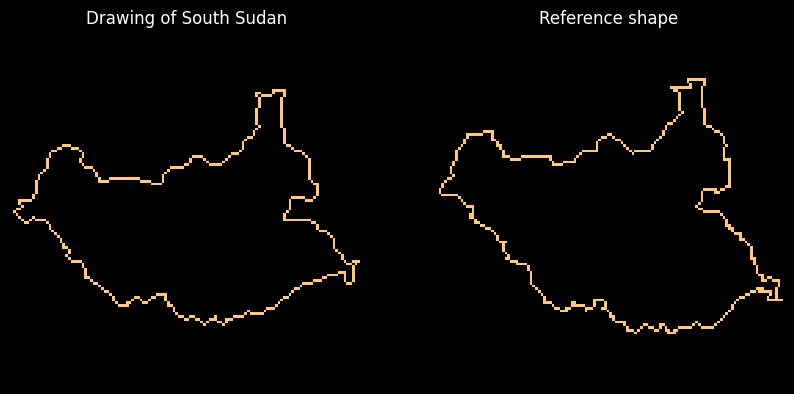

In [63]:
plot_sample(test_data, idx=77)